In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss, MSELoss
from transformers import RobertaTokenizerFast, RobertaConfig, RobertaModel, RobertaForSequenceClassification, get_linear_schedule_with_warmup
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from model import Model
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizerFast.from_pretrained("microsoft/codebert-base", do_lower_case=True)

config = RobertaConfig.from_pretrained("microsoft/codebert-base")
config.num_labels = 1
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", config=config)
model.to(device)
model = Model(model)
model.to(device)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Model(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(i

In [39]:
max_length = 512

def convert_examples_to_features(js):
    code=' '.join(js['func'].split())
    inputs = tokenizer(
        code, 
        max_length=max_length, 
        return_tensors="pt",
        padding="max_length",
        truncation=True
    )
    return inputs, js['target']

def convert_examples_to_features2(js):
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code, return_tensors="pt", max_length=510, padding="max_length")[:510]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    source_ids = torch.tensor(source_ids)
    return {"input_ids": source_ids, "attention_mask": source_ids.ne(1)}, js['target']

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features2(js))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):       
        return self.examples[i][0], self.examples[i][1]

In [40]:
train_dataset = CustomDataset('dataset/train.jsonl')

In [41]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [42]:
test_dataset = CustomDataset('dataset/test.jsonl')
batch_size = 4
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

In [43]:
adam_epsilon = 1e-8
learning_rate = 2e-5
max_grad_norm = 1.0
weight_decay = 0.00
no_decay = ['bias', 'LayerNorm.weight']
epochs = 5
max_steps = epochs * len(train_dataloader)
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=max_steps * 0.1, num_training_steps=max_steps)

In [36]:
update_loss_steps = 100

In [44]:
stats = []
for i, epoch in enumerate(range(epochs)):
    #TRAINING
    bar = tqdm(train_dataloader,total=len(train_dataloader))
    bar.set_description(f"Epoch {epoch}")
    model.train()
    total_loss = 0
    val_results = []
    val_labels = []
    for step, batch in enumerate(bar):
        inputs = batch[0]
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
        labels = batch[1].to(device)

        outputs = model(**inputs)
        result = outputs[:,0]
        #test = labels*2-1
        #loss = MSELoss()(result, test.float())
        loss = BCEWithLogitsLoss()(result, labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        total_loss += loss.mean().item()
        val_results.append(result.cpu().detach().numpy())
        val_labels.append(labels.cpu().numpy())
        if step % update_loss_steps == 99:
            results=np.concatenate(val_results,0)
            labels=np.concatenate(val_labels,0)
            preds=results>0.5
            eval_acc=np.mean(labels==preds)
            loss = total_loss / step
            stats.append({'steps': (epoch*len(train_dataloader))+step, 'loss': loss, 'acc': eval_acc})
            bar.set_description(f"Epoch {epoch}: loss {loss:.4f}, acc {eval_acc:.4f}")
    
    #EVAL
    model.eval()
    with torch.no_grad():
        bar = tqdm(test_dataloader,total=len(test_dataloader))
        total_loss = 0
        val_results = []
        val_labels = []
        for step, batch in enumerate(bar):
            inputs = batch[0]
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = batch[1].to(device)

            outputs = model(**inputs)
            result = outputs[:,0]
            loss = BCEWithLogitsLoss()(result, labels.float())
            total_loss += loss.mean().item()
            val_results.append(result.cpu().detach().numpy())
            val_labels.append(labels.cpu().numpy())
    results=np.concatenate(val_results,0)
    labels=np.concatenate(val_labels,0)
    preds=results>0.5
    eval_acc=np.mean(labels==preds)
    loss = total_loss / step
    time.sleep(1)
    print(f"Test set: loss {loss:.4f}, acc {eval_acc:.4f}")
    model.save_pretrained('models2/epoch'+str(epoch))

100%|██████████| 683/683 [00:41<00:00, 16.34it/s]


Test set: loss 0.6674, acc 0.5974


Epoch 1: loss 0.6459, acc 0.6125:   9%|▉         | 494/5464 [01:38<16:27,  5.04it/s]

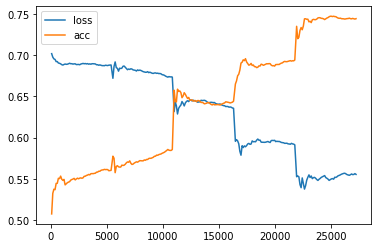

In [9]:
plt.plot([s['steps'] for s in stats], [s['loss'] for s in stats])
plt.plot([s['steps'] for s in stats], [s['acc'] for s in stats])
plt.legend(['loss', 'acc'])
plt.show()

In [14]:
config = RobertaConfig.from_pretrained("microsoft/codebert-base")
config.num_labels = 1
model = RobertaForSequenceClassification.from_pretrained("models/epoch4", config=config)
model.to(device)
model = Model(model)
model.to(device)

model.eval()
with torch.no_grad():
    bar = tqdm(test_dataloader,total=len(test_dataloader))
    total_loss = 0
    val_results = []
    val_labels = []
    for step, batch in enumerate(bar):
        inputs = batch[0]
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
        labels = batch[1].to(device)

        outputs = model(**inputs)
        result = outputs[:,0]
        loss = BCEWithLogitsLoss()(result, labels.float())
        total_loss += loss.mean().item()
        val_results.append(result.cpu().detach().numpy())
        val_labels.append(labels.cpu().numpy())
results=np.concatenate(val_results,0)
labels=np.concatenate(val_labels,0)
preds=results>0.5
eval_acc=np.mean(labels==preds)
loss = total_loss / step
time.sleep(1)
print(f"loss {loss:.4f}, acc {eval_acc:.4f}")

100%|██████████| 683/683 [00:41<00:00, 16.29it/s]


loss 0.8321, acc 0.6270
